In [19]:
import numpy as np
import cv2
import msgpack as msgp
import msgpack_numpy as mpn
import glob
import os
import matplotlib.pyplot as plt
import mediapipe as mp
from pprint import pprint
import pandas as pd
from support.funcs import RMSE
from pptx import Presentation
from pptx.util import Inches

playback=False

In [20]:
def is_fourcc_available(codec):
    try:
        fourcc = cv2.VideoWriter_fourcc(*codec)
        temp_video = cv2.VideoWriter('temp.mkv', fourcc, 30, (640, 480), isColor=True)
        return temp_video.isOpened()
    except:
        return False

def enumerate_fourcc_codecs():
    codecs_to_test = ["XVID","RGBA","MJPG","IYUV","mp4v","b48r"]
    available_codecs = []
    for codec in codecs_to_test:
        available_codecs.append((codec, is_fourcc_available(codec)))
    return available_codecs

codecs = enumerate_fourcc_codecs()
print("Available FourCC codecs:")
pprint(codecs)

Available FourCC codecs:
[('XVID', True),
 ('RGBA', True),
 ('MJPG', True),
 ('IYUV', True),
 ('mp4v', True),
 ('b48r', True)]


In [21]:
def apply_median_filter(dataframe, window_size=10):
    # Iterate over all columns except the first one
    for column_name in dataframe.columns[1:]:
        # Get the column data as a NumPy array
        column_data = dataframe[column_name].values

        # Apply the median filter
        filtered_data = np.zeros_like(column_data)
        padding = window_size // 2  # Number of elements to pad on each side
        for i in range(padding, len(column_data) - padding):
            window = column_data[i - padding:i + padding + 1]
            filtered_data[i] = np.median(window)

        # Replace the original column with the filtered data
        dataframe[column_name] = filtered_data


In [22]:
#getting the raw data and running the model

# Setting the parameters of the stream
h=480 #720 
w=640 #1280
fps=30
windowscale=0.6

def midpoint(p1,p2):
    '''
    calculates the midpoint of two points
    p1,p2 : lists/like representing the points
    returns : midpoint
    '''
    mid=[]
    for i in range(len(p1)):
        mid.append((p1[i]+p2[i])/2)
    return mid

# Initializing the model to locate the landmarks
mp_holistic = mp.solutions.holistic
holistic_model = mp_holistic.Holistic(
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)

# Initializing the landmark lists
LS, LE, LW, RS, RE, RW, TR = [], [], [], [], [], [], []
RI,LI=[],[]
 
# Initializing the drawing utils for drawing the facial landmarks on image
mp_drawing = mp.solutions.drawing_utils
 
# Initializing current time and precious time for calculating the FPS
previousTime = 0
currentTime = 0

frames=0

pth = r"C:\Users\arpan\OneDrive\Documents\internship\rec_program\savdir\Session 19-06-23_12-14-21_2341"

lst = os.listdir(pth)
vid_name = lst[-1]

targetPattern = f"{pth}\\DEPTH*"
campth = glob.glob(targetPattern)

targetPattern_param = f"{pth}\\PARAM*"
ppth = glob.glob(targetPattern_param)

targetPattern_colour = f"{pth}\\COLOUR*"
cpth = glob.glob(targetPattern_colour)

img = []
c=0
for i in cpth:
    print(i)
    col_file = open(i, "rb")
    unpacker = None
    unpacker = msgp.Unpacker(col_file, object_hook=mpn.decode)
    for unpacked in unpacker:
        c+=1

        unpacked=cv2.flip(unpacked,1)
        imagep=unpacked

        # Making predictions using holistic model
        # To improve performance, optionally mark the image as not writeable to
        # pass by reference.
        imagep.flags.writeable = False
        results = holistic_model.process(imagep)
        imagep.flags.writeable = True

        # Converting back the RGB image to BGR
        color_image = imagep

        #Drawing the pose landmarks
        mp_drawing.draw_landmarks(
        imagep,
        results.pose_landmarks,
        mp_holistic.POSE_CONNECTIONS)

        # Calculating the FPS
        currentTime = time.time()
        fps = 1 / (currentTime-previousTime)
        previousTime = currentTime

        # Displaying FPS on the image
        cv2.putText(imagep, str(int(fps))+" FPS", (10, 70), cv2.FONT_HERSHEY_COMPLEX, 1, (0,255,0), 2)
        cv2.putText(imagep, str(int(frames))+' total_frames', (500, 70), cv2.FONT_HERSHEY_COMPLEX, 1, (0,255,0), 2)
        frames+=1

        # Finding and saving the landmark positions        
        try:
            dic = {}
            for mark, data_point in zip(mp_holistic.PoseLandmark, results.pose_landmarks.landmark):
                dic[mark.value] = dict(landmark = mark.name, 
                    x = data_point.x,
                    y = data_point.y)        
            try:
                LS.append([dic[11]['x']*w,dic[11]['y']*h])
            except:
                LS.append(np.nan)
            try:
                LE.append([dic[13]['x']*w,dic[13]['y']*h])
            except:
                LE.append(np.nan)
            try:
                LW.append([dic[15]['x']*w,dic[15]['y']*h])
            except:
                LW.append(np.nan)
            try:
                RS.append([dic[12]['x']*w,dic[12]['y']*h])
            except:
                RS.append(np.nan)
            try:
                RE.append([dic[14]['x']*w,dic[14]['y']*h])
            except:
                RE.append(np.nan)
            try:
                RW.append([dic[16]['x']*w,dic[16]['y']*h])
            except:
                RW.append(np.nan)
            
            try:
                Smid=midpoint([dic[11]['x']*w,dic[11]['y']*h],[dic[12]['x']*w,dic[12]['y']*h])
                perpx=int(Smid[0])
                perpy=(int(Smid[1])+25)

                cv2.circle(color_image,(perpx,perpy) , 5, (0, 0, 255), 2)
                TR.append([perpx,perpy])     #in uv format  
            except:
                TR.append(np.nan)

            try:
                RI.append([dic[20]['x']*w,dic[20]['y']*h])
                LI.append([dic[19]['x']*w,dic[19]['y']*h])
            except:
                RI.append(np.nan)
                LI.append(np.nan)
        except:
            LS.append(np.nan)
            LE.append(np.nan)
            LW.append(np.nan)

            RS.append(np.nan)
            RE.append(np.nan)
            RW.append(np.nan)

            TR.append(np.nan) 
            RI.append(np.nan)
            LI.append(np.nan)
            pass 
        
        if playback:
            # Display the resulting image
            cv2.imshow("Pose Landmarks", imagep)

        # Enter key 'q' to break the loopqq
        if cv2.waitKey(5) & 0xFF == ord('q'):
            break
         
        img.append(unpacked)
        #cv2.imshow("sadf", unpacked)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
        try:
            if (unpacked)==-1:
                cv2.destroyAllWindows()
                break
        except:
            continue
    col_file.close()

cv2.destroyAllWindows()

print(f"Frames extracted: {c}")
print("Extraction of raw .msgpack files complete!")


C:\Users\arpan\OneDrive\Documents\internship\rec_program\savdir\Session 19-06-23_12-14-21_2341\COLOUR_19-06-23_12-14-21_234_1.msgpack
C:\Users\arpan\OneDrive\Documents\internship\rec_program\savdir\Session 19-06-23_12-14-21_2341\COLOUR_19-06-23_12-14-21_234_2.msgpack
C:\Users\arpan\OneDrive\Documents\internship\rec_program\savdir\Session 19-06-23_12-14-21_2341\COLOUR_19-06-23_12-14-21_234_3.msgpack
C:\Users\arpan\OneDrive\Documents\internship\rec_program\savdir\Session 19-06-23_12-14-21_2341\COLOUR_19-06-23_12-14-21_234_4.msgpack
Frames extracted: 349
Extraction of raw .msgpack files complete!


In [23]:
def landmarks_to_df(land_marks = {'LS': LS, 'LE': LE, 'LW': LW, 'RS': RS, 'RE': RE, 'RW': RW, 'TR': TR}):
    import numpy as np
    pos = []
    c=0
    for i in campth:
        depth_file = open(i, "rb")
        unpacker = None
        unpacker = msgp.Unpacker(depth_file, object_hook=mpn.decode)
        for unpacked in unpacker:
            #_tmp = np.array(unpacked)
            #print(_tmp.shape)
            #print('loop running',c)
            c+=1
            #print(unpacked)
            
            #  unpacked = cv2.resize(unpacked, (800, 600))
            #  unpacked=cv2.flip(unpacked,1)

            pos.append(unpacked)
        depth_file.close()

    cv2.destroyAllWindows()
    pos=np.array(pos)

    #obtaining list time_stamps
    p = open(ppth[0], "rb")
    unpacker=None
    unpacker = msgp.Unpacker(p, object_hook=mpn.decode)
    prm = []
    for unpacked in unpacker:
        prm.append(unpacked)

    prm_md=prm

    prm_md.pop(0)
    prm_md.pop(0)

    time_stamps=[]

    for i in prm_md:
        time_stamps.append(i[0])


    for i in range(len(time_stamps)):
        time_stamps[i]=float(time_stamps[i]/1000)

    timestamps=time_stamps
    
    # Saving landmark positions to a dataframe

    pos = np.array(pos)

    df = pd.DataFrame()
    xyz = ['_x', '_y', '_z']

    # Adding the 'epoch_time' column to the DataFrame using timestamps
    df['epoch_time'] = pd.Series(timestamps)

    # Iterate through each landmark in the dictionary
    for key, value in land_marks.items():    
        for j in range(3):
            data = []
            # Iterate through each position in 'pos' array
            for i in range(len(pos)):
                try:
                    # Extract the corresponding coordinate value from 'pos' array
                    x = pos[i][int((value[i][1]))][int((value[i][0]))][j]
                    data.append(x)
                except:
                    continue
            # Add the extracted coordinate data as a new column in the DataFrame
            df[key + xyz[j]] = pd.Series(data)

    return df

In [24]:
raw=landmarks_to_df({'LS': LS, 'LE': LE, 'LW': LW, 'RS': RS, 'RE': RE, 'RW': RW, 'TR': TR})
apply_median_filter(raw)

In [25]:
def extract_frames_from_avi(avi_file):
    # Open the .avi file
    video = cv2.VideoCapture(avi_file)

    # Initializing the landmark lists
    LS, LE, LW, RS, RE, RW, TR = [], [], [], [], [], [], []
    RI,LI=[],[]

    # Initializing current time and precious time for calculating the FPS
    previousTime = 0
    currentTime = 0

    # Check if the video file was successfully opened
    if not video.isOpened():
        print("Error opening video file:", avi_file)
        return
    
    # Read and save each frame until the end of the video
    frame_count = 0
    frames=0
    while True:

        # Read the next frame
        ret, frame = video.read()

        # Break the loop if no more frames are available
        if not ret:
            break
        
        frame_count += 1
        c=frame_count
        
        imagep=cv2.flip(frame,1)

        # Making predictions using holistic model
        # To improve performance, optionally mark the image as not writeable to
        # pass by reference.
        imagep.flags.writeable = False
        results = holistic_model.process(imagep)
        imagep.flags.writeable = True

        # Converting back the RGB image to BGR
        color_image = imagep

        #Drawing the pose landmarks
        mp_drawing.draw_landmarks(
        imagep,
        results.pose_landmarks,
        mp_holistic.POSE_CONNECTIONS)

        # Calculating the FPS
        currentTime = time.time()
        fps = 1 / (currentTime-previousTime)
        previousTime = currentTime

        # Displaying FPS on the image
        cv2.putText(imagep, str(int(fps))+" FPS", (10, 70), cv2.FONT_HERSHEY_COMPLEX, 1, (0,255,0), 2)
        cv2.putText(imagep, str(int(frames))+' total_frames', (500, 70), cv2.FONT_HERSHEY_COMPLEX, 1, (0,255,0), 2)
        frames+=1

        # Finding and saving the landmark positions        
        try:
            dic = {}
            for mark, data_point in zip(mp_holistic.PoseLandmark, results.pose_landmarks.landmark):
                dic[mark.value] = dict(landmark = mark.name, 
                    x = data_point.x,
                    y = data_point.y)   
            try:
                LS.append([dic[11]['x']*w,dic[11]['y']*h])
            except:
                LS.append(np.nan)
            try:
                LE.append([dic[13]['x']*w,dic[13]['y']*h])
            except:
                LE.append(np.nan)
            try:
                LW.append([dic[15]['x']*w,dic[15]['y']*h])
            except:
                LW.append(np.nan)
            try:
                RS.append([dic[12]['x']*w,dic[12]['y']*h])
            except:
                RS.append(np.nan)
            try:
                RE.append([dic[14]['x']*w,dic[14]['y']*h])
            except:
                RE.append(np.nan)
            try:
                RW.append([dic[16]['x']*w,dic[16]['y']*h])
            except:
                RW.append(np.nan)
            
            try:
                Smid=midpoint([dic[11]['x']*w,dic[11]['y']*h],[dic[12]['x']*w,dic[12]['y']*h])
                perpx=int(Smid[0])
                perpy=(int(Smid[1])+25)

                cv2.circle(color_image,(perpx,perpy) , 5, (0, 0, 255), 2)
                TR.append([perpx,perpy])     #in uv format  
            except:
                TR.append(np.nan)

            try:
                RI.append([dic[20]['x']*w,dic[20]['y']*h])
                LI.append([dic[19]['x']*w,dic[19]['y']*h])
            except:
                RI.append(np.nan)
                LI.append(np.nan)
        except:
            LS.append(np.nan)
            LE.append(np.nan)
            LW.append(np.nan)

            RS.append(np.nan)
            RE.append(np.nan)
            RW.append(np.nan)

            TR.append(np.nan) 
            RI.append(np.nan)
            LI.append(np.nan)
            pass 
        
        if playback:
            # Display the resulting image
            directory, filename = os.path.split(avi_file)
            cv2.imshow("Pose Landmarks "+filename, imagep)

        # Enter key 'q' to break the loopqq
        if cv2.waitKey(5) & 0xFF == ord('q'):
            break
         
        img.append(unpacked)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    col_file.close()
    cv2.destroyAllWindows()

    # Release the video capture object
    video.release()

    print(f"Frames extracted: {frame_count}")
    print("Extraction complete!")
    return {'LS': LS, 'LE': LE, 'LW': LW, 'RS': RS, 'RE': RE, 'RW': RW, 'TR': TR}


In [26]:
import pandas as pd
xvid,iyuv,mjpg,mp4v,b48r=pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame()

In [27]:
# xvid dataframe
try:
    avi_file_path = pth+r"\Videoxvid.avi"
    landmarksxvid=extract_frames_from_avi(avi_file_path)
    xvid=landmarks_to_df(landmarksxvid)
    apply_median_filter(xvid)
except:
    pass

Frames extracted: 349
Extraction complete!


In [28]:
# iyuv dataframe
try:
    avi_file_path = pth+r"\Videoiyuv.avi"
    landmarksiyuv=extract_frames_from_avi(avi_file_path)
    iyuv=landmarks_to_df(landmarksiyuv)
    apply_median_filter(iyuv)
except:
    pass

Frames extracted: 349
Extraction complete!


In [29]:
# mjpg dataframe
try:
    avi_file_path = pth+r"\Videomjpg.avi"
    landmarksmjpg=extract_frames_from_avi(avi_file_path)
    mjpg=landmarks_to_df(landmarksmjpg)
    apply_median_filter(mjpg)
except:
    pass

Frames extracted: 349
Extraction complete!


In [30]:
# mp4v dataframe
try:
    avi_file_path = pth+r"\Videomp4v.avi"
    landmarksmp4v=extract_frames_from_avi(avi_file_path)
    mp4v=landmarks_to_df(landmarksmp4v)
    apply_median_filter(mp4v)
except:
    pass

Frames extracted: 349
Extraction complete!


In [31]:
# b48r dataframe
try:
    avi_file_path = pth+r"\Videob48r.avi"
    landmarksb48r=extract_frames_from_avi(avi_file_path)
    b48r=landmarks_to_df(landmarksb48r)
    apply_median_filter(b48r)
except:
    pass

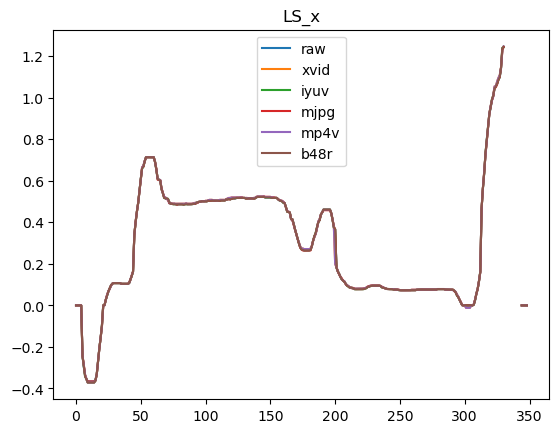

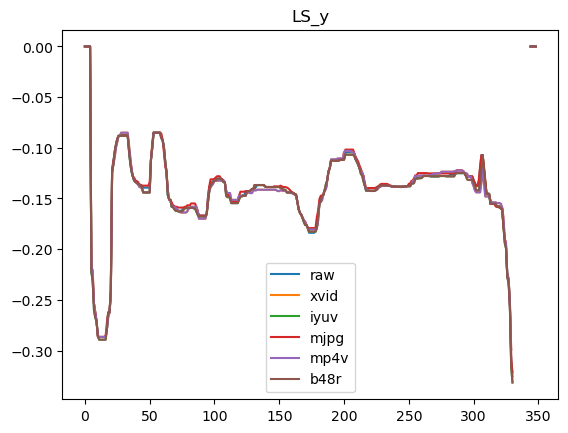

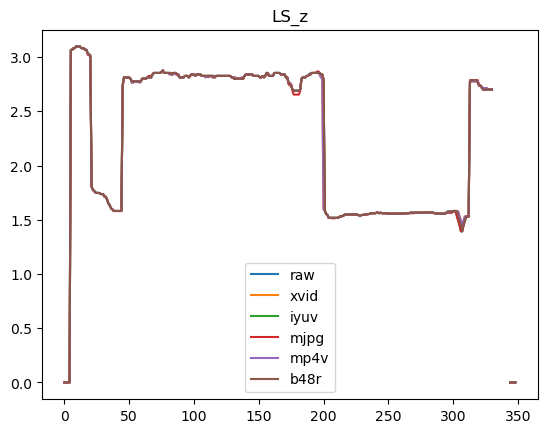

In [ ]:
# Get the list of column names from 'raw' dataframe, excluding the first column
columns = raw.columns.tolist()[1:]

# Create a list of dataframes and their respective names
dfs = [raw, xvid, iyuv, mjpg, mp4v, b48r]
dfnames = ['raw', 'xvid', 'iyuv', 'mjpg', 'mp4v', 'b48r']

c = 0  # Counter variable

# Iterate over each column name
for i in columns:
    try:
        # Create a new figure and axis
        fig, ax = plt.subplots()

        # Plot the data from each dataframe for the current column
        for j in range(len(dfnames)):
            ax.plot(dfs[j].index, dfs[j][i])

        plt.legend(dfnames)  # Add legend with dataframe names
        plt.title(i)  # Set the title of the plot as the column name
        plt.show()  # Display the plot

    except:
        continue

    c += 1

    # Break the loop after displaying plots for 3 columns
    if c == 3:
        break


C:\Users\arpan\AppData\Local\Temp\ipykernel_7920\2590739468.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


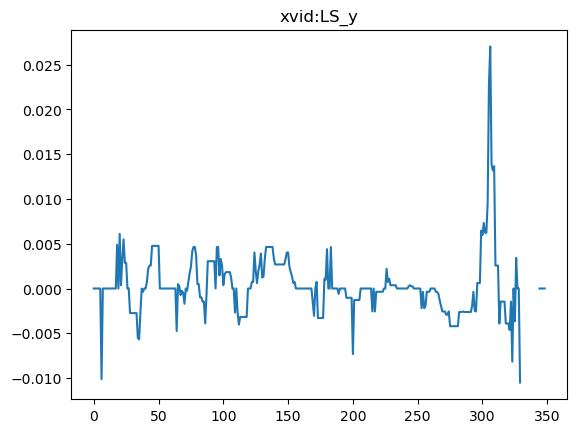

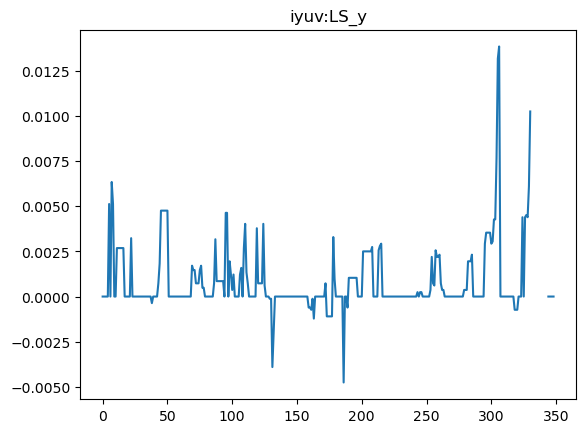

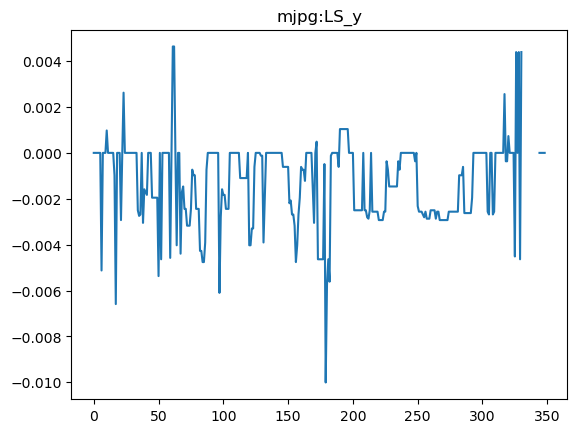

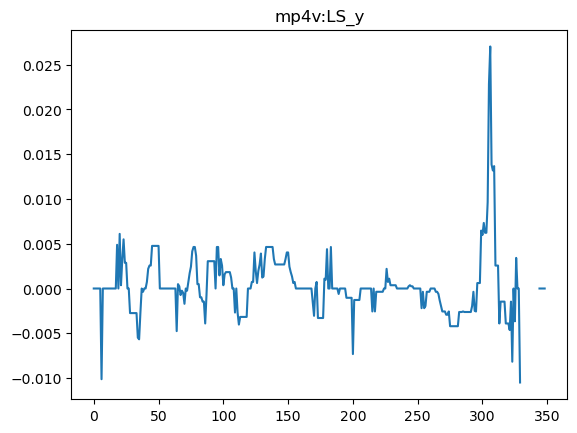

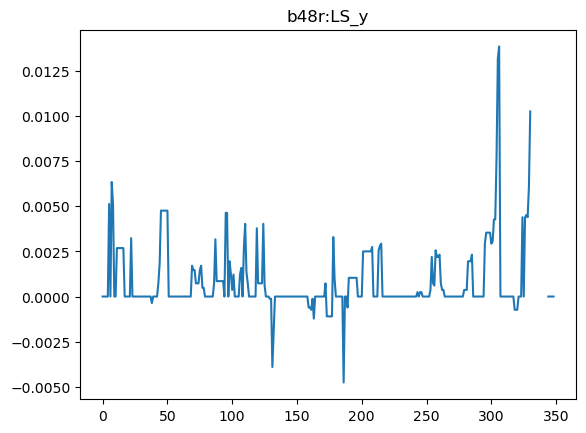

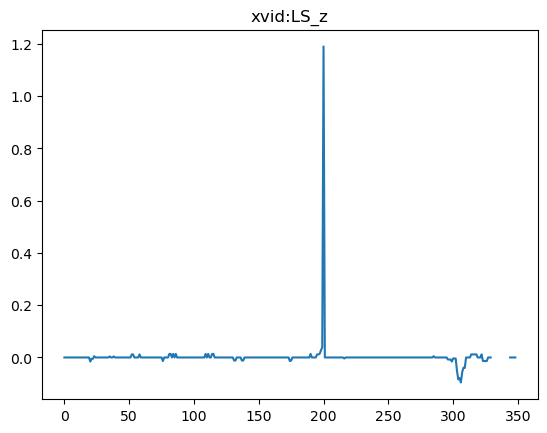

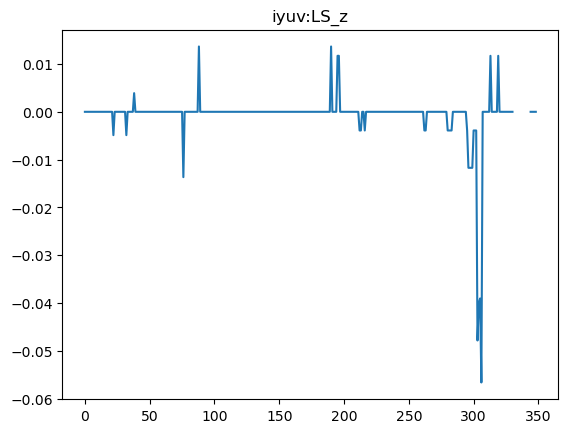

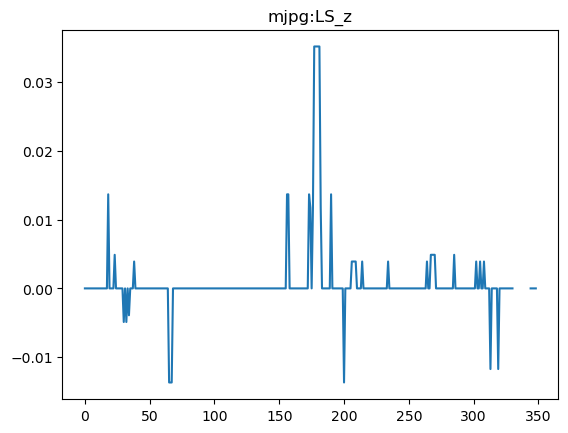

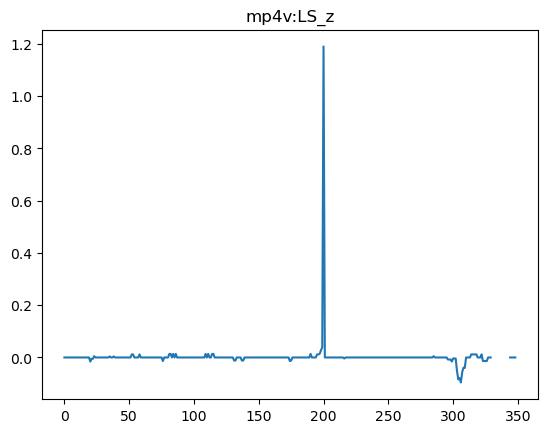

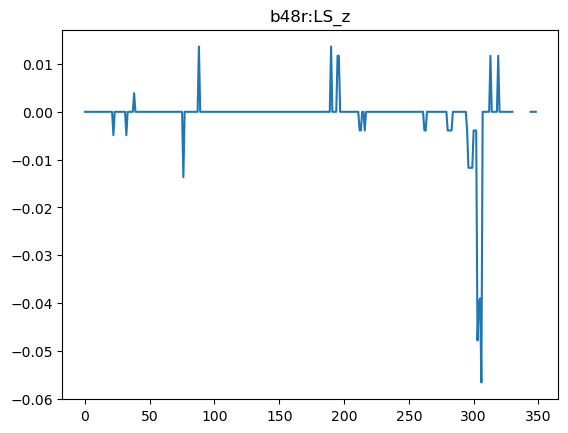

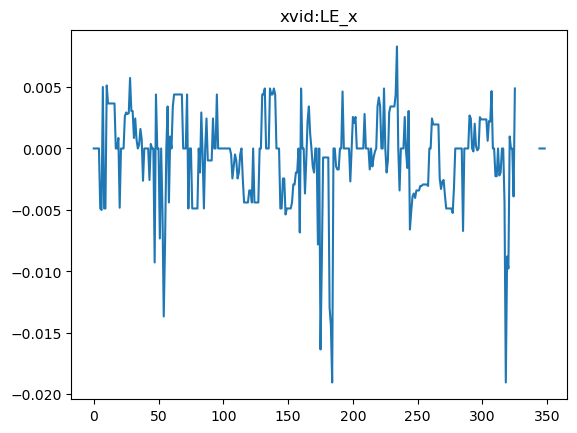

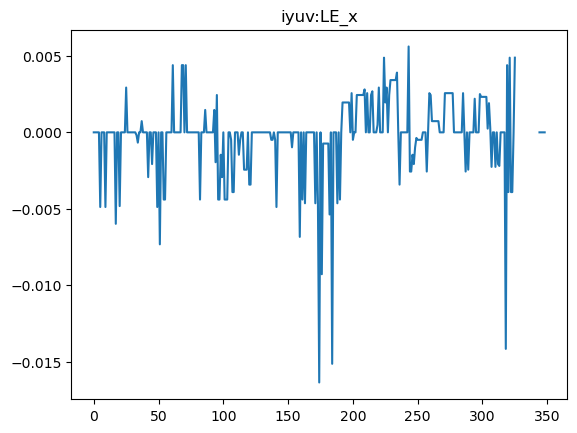

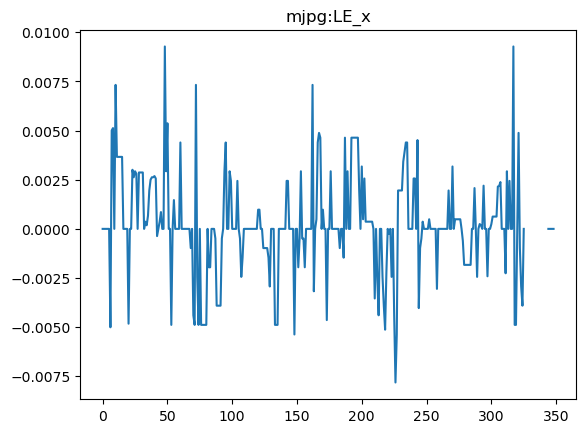

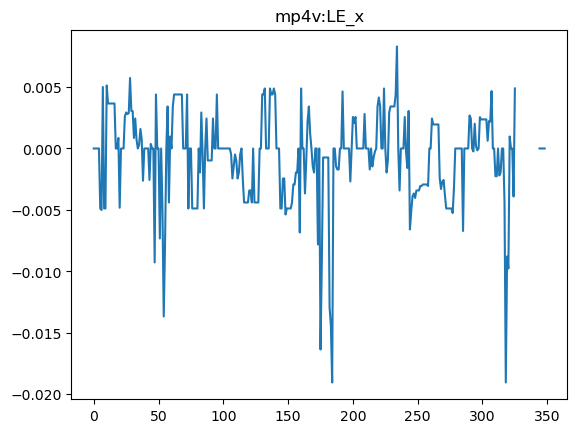

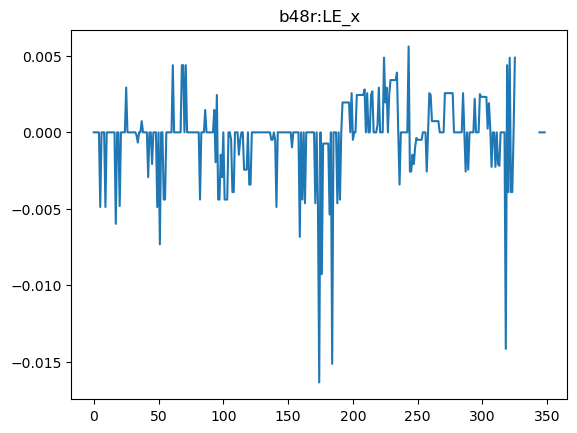

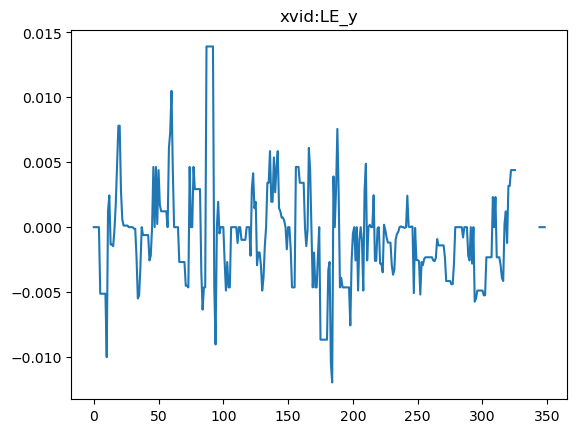

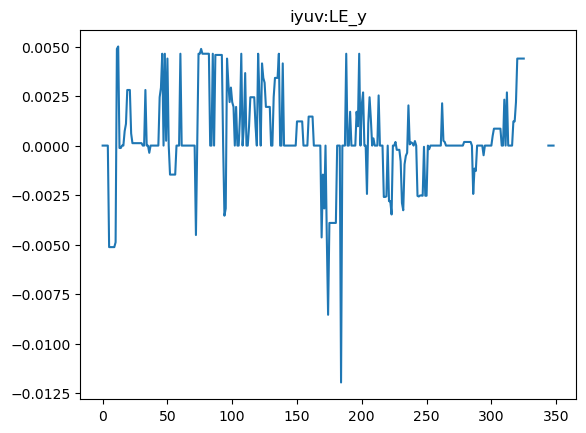

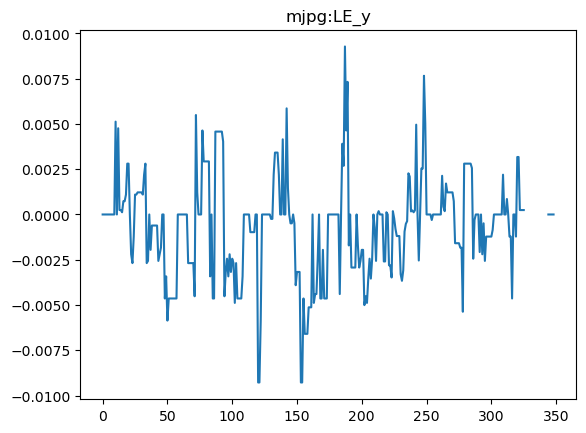

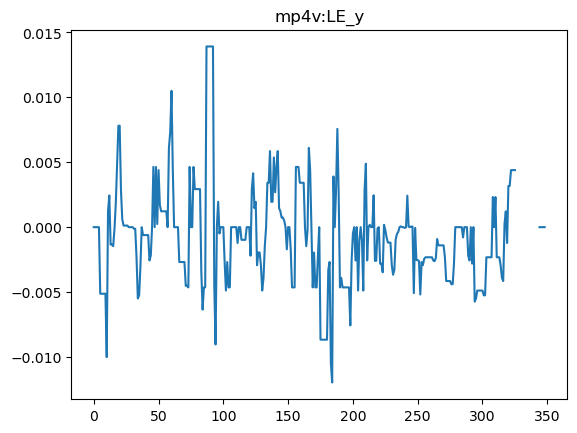

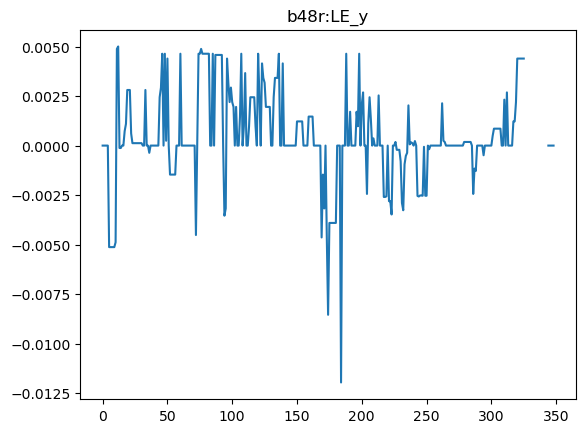

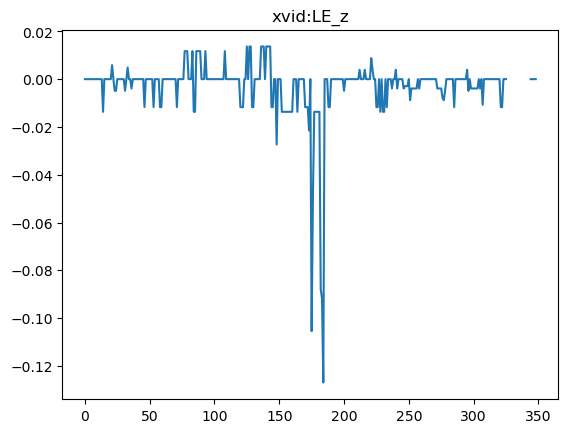

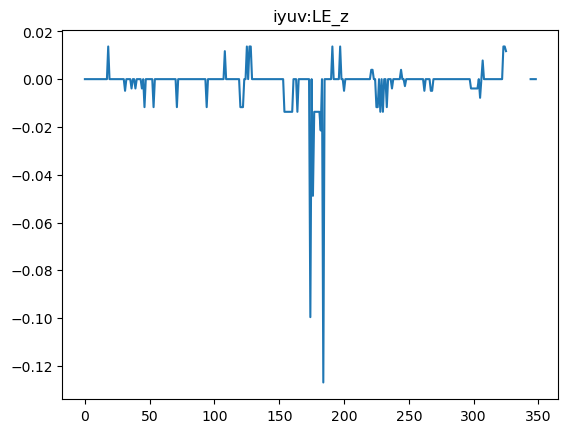

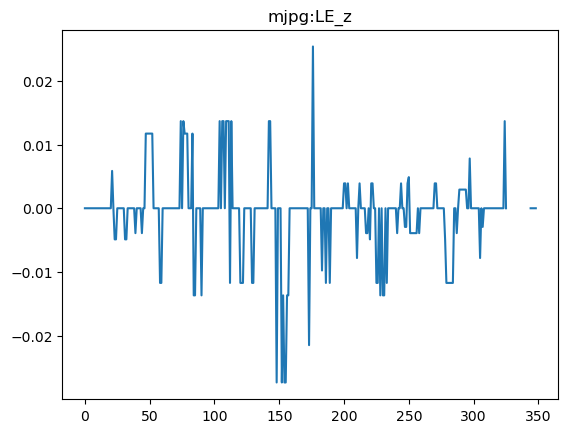

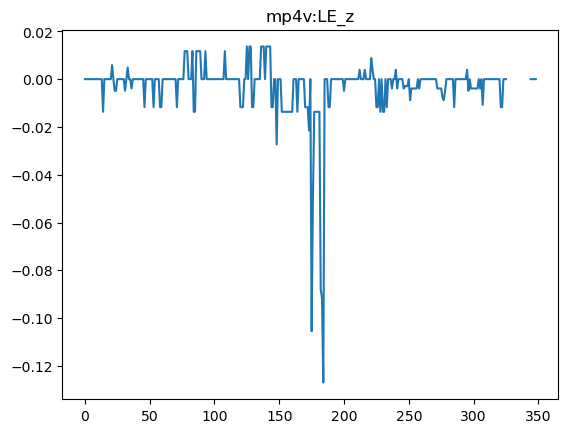

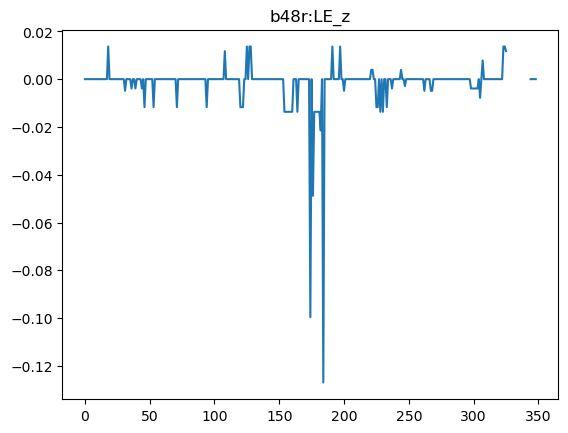

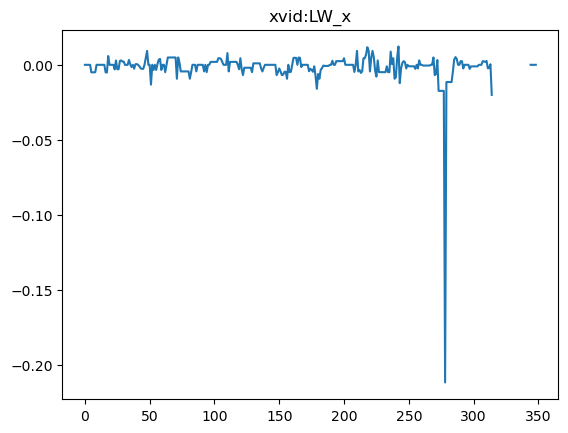

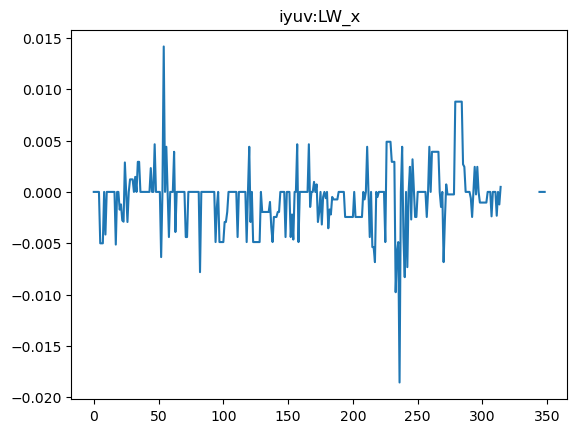

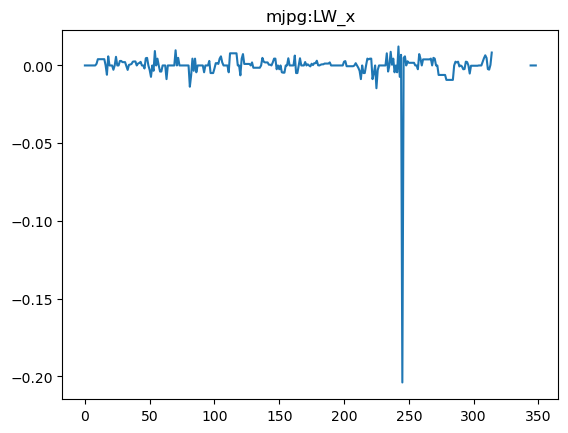

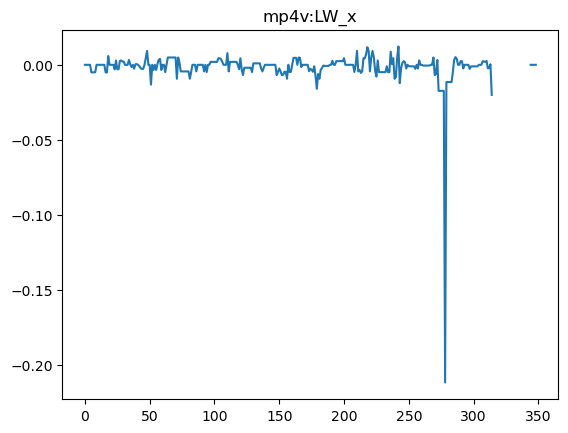

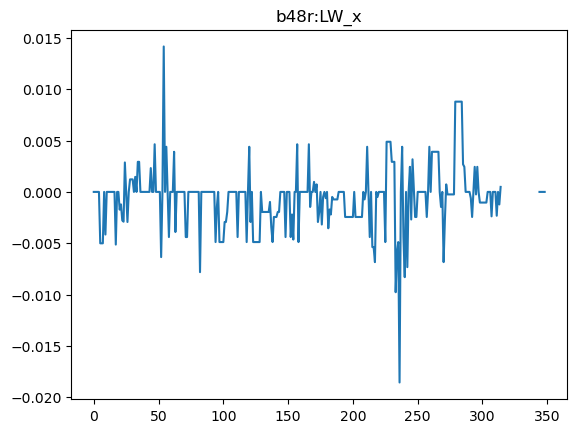

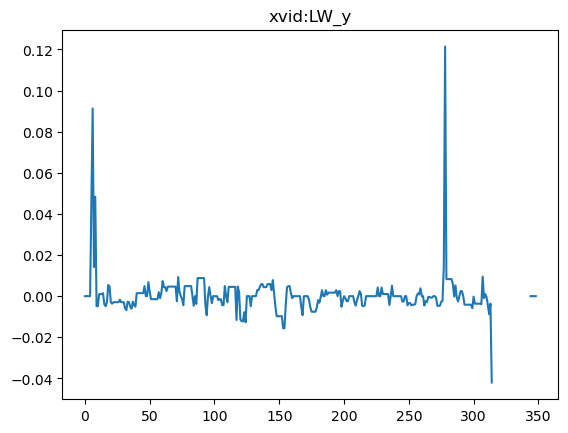

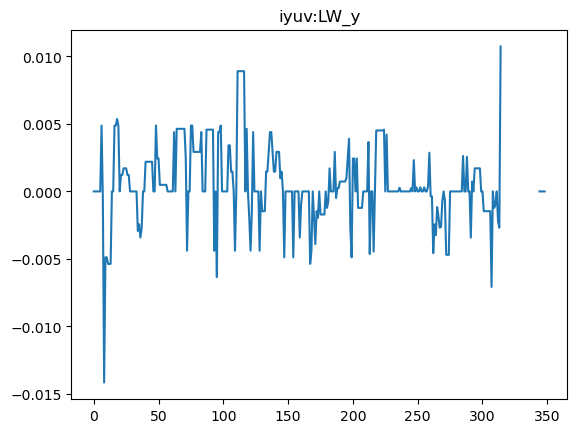

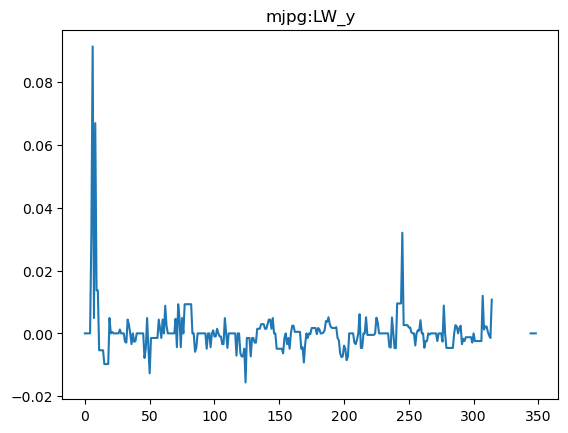

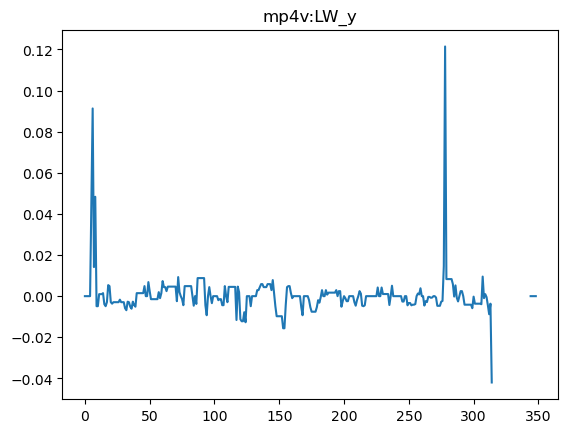

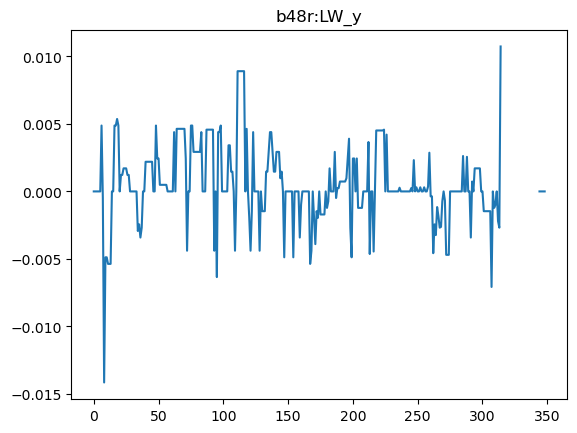

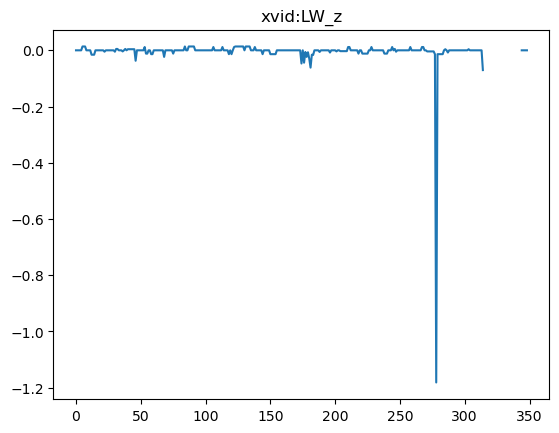

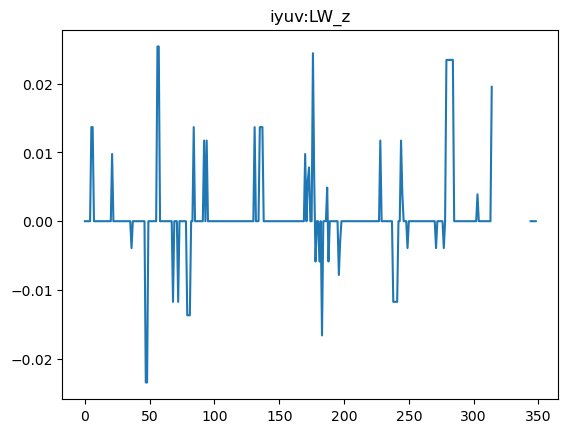

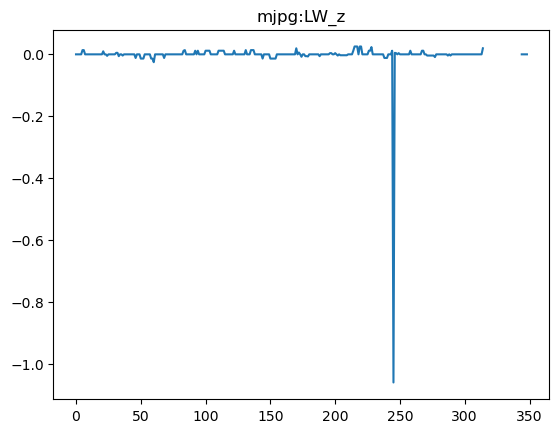

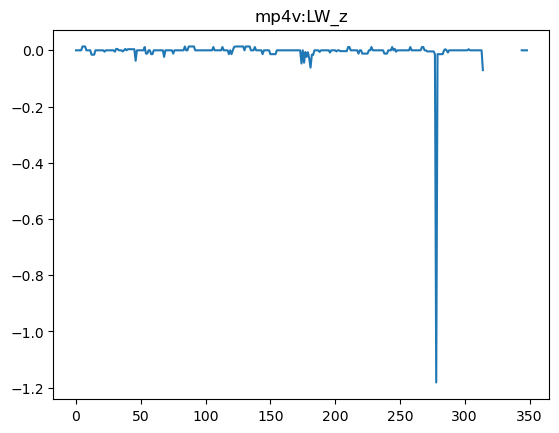

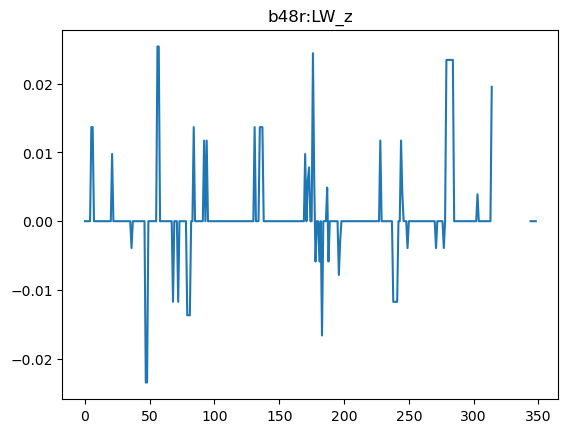

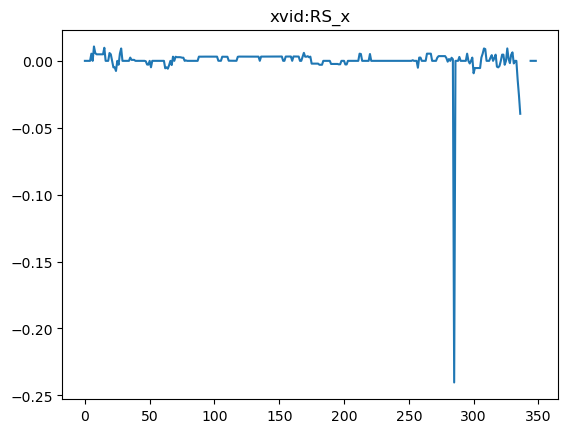

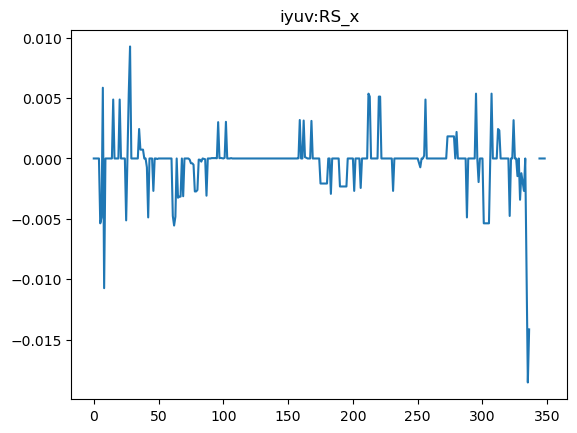

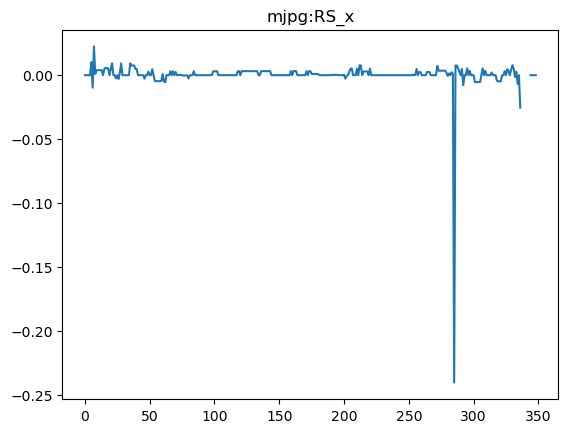

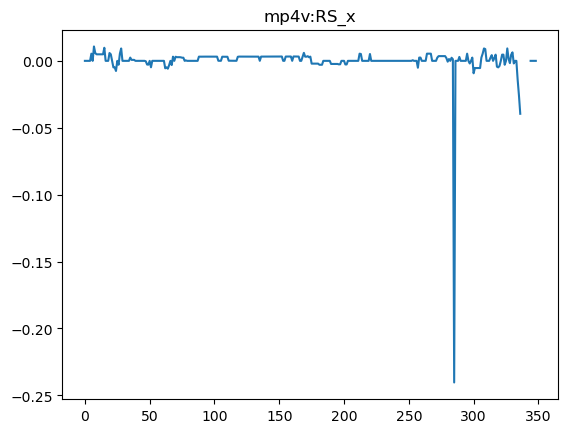

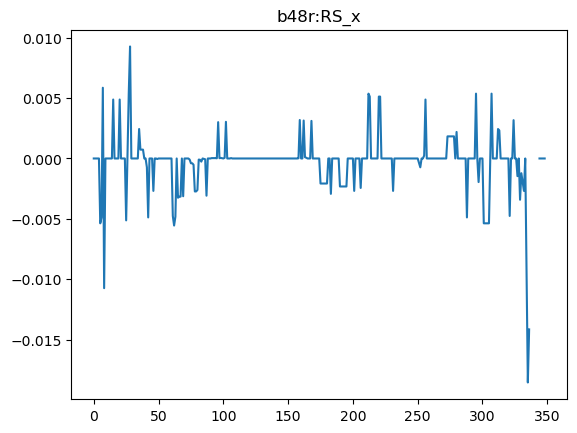

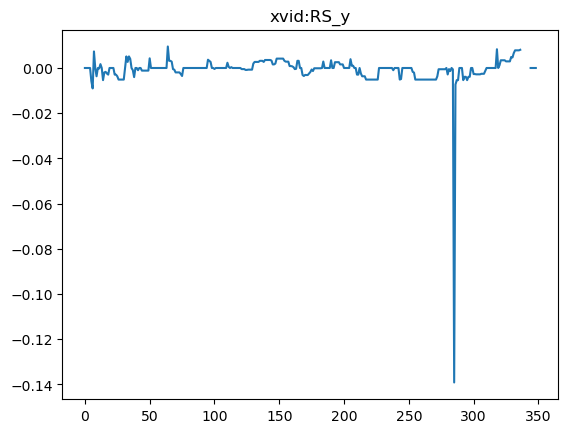

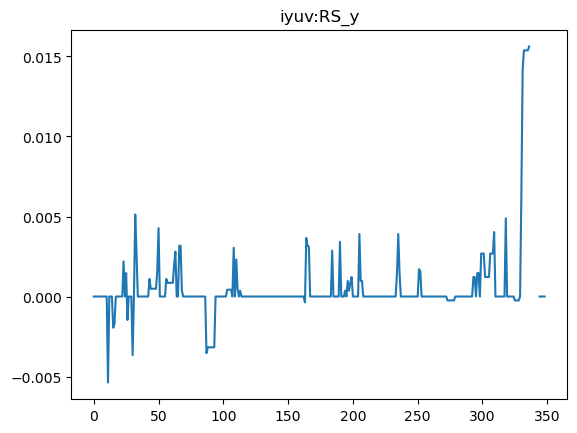

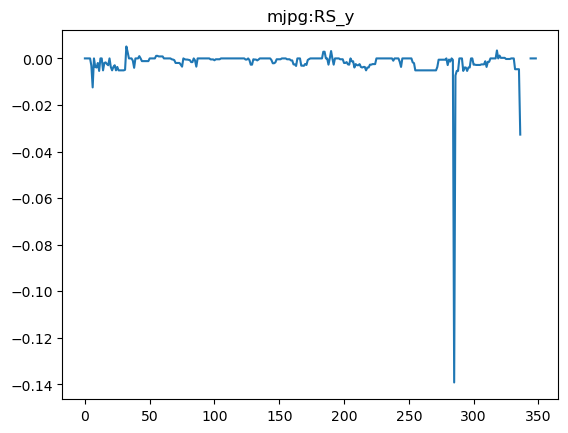

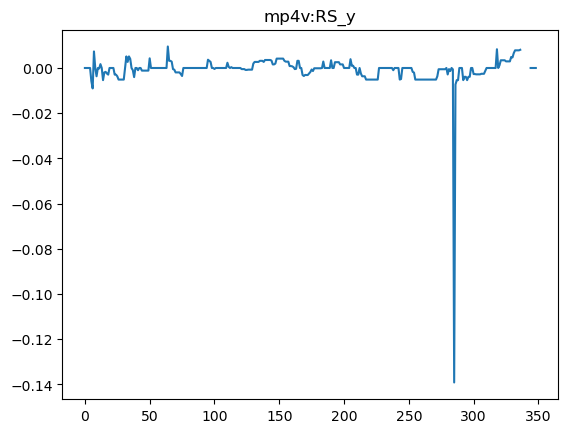

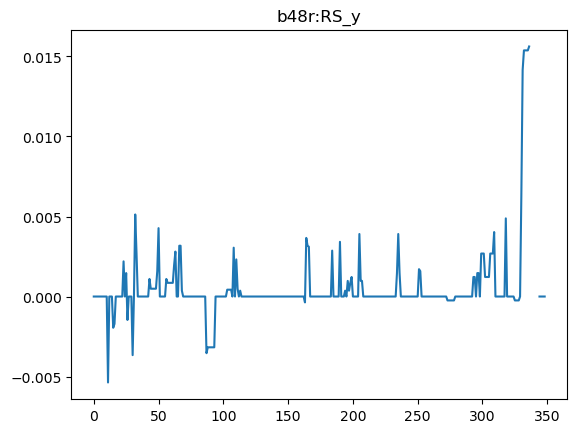

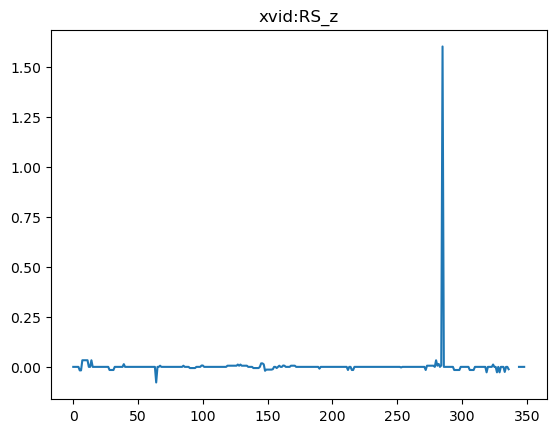

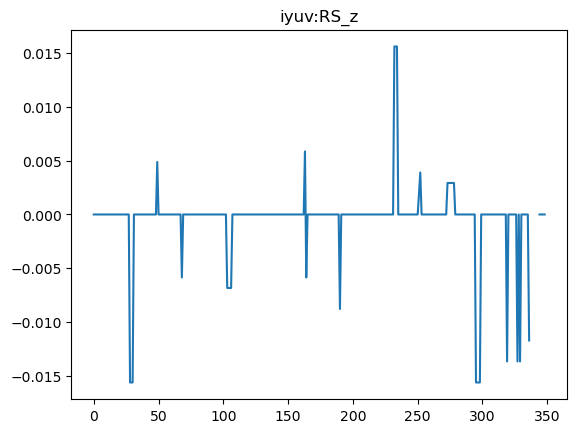

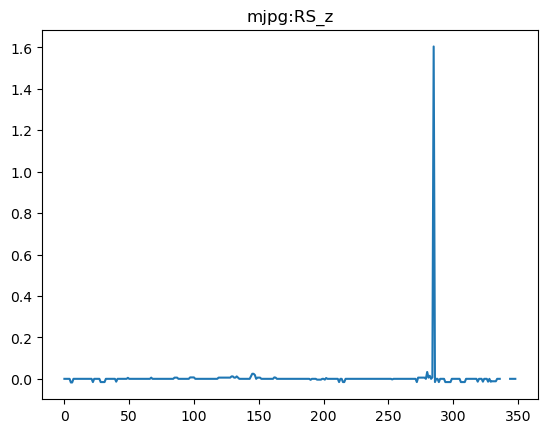

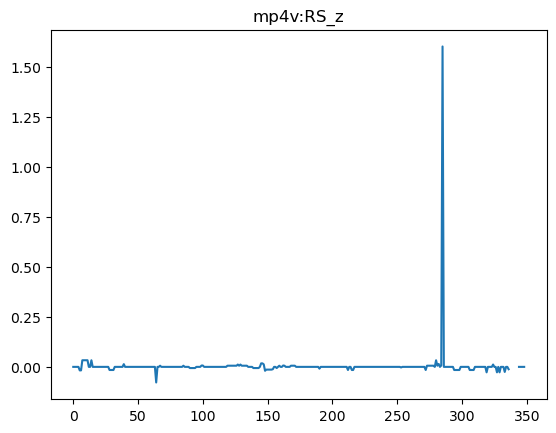

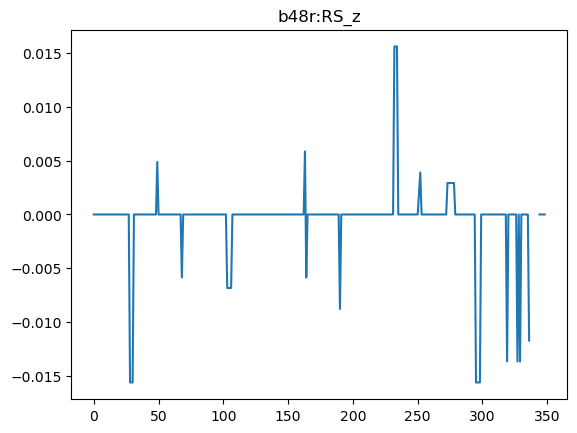

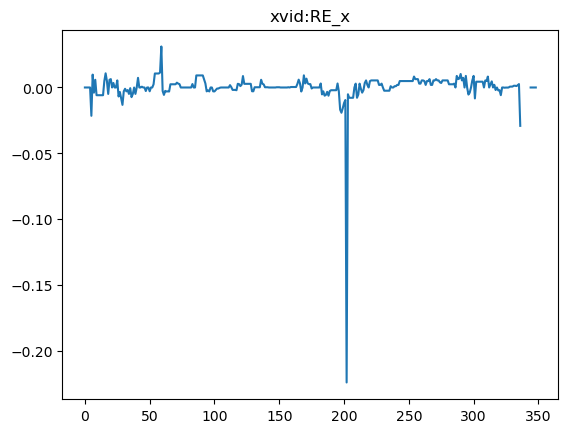

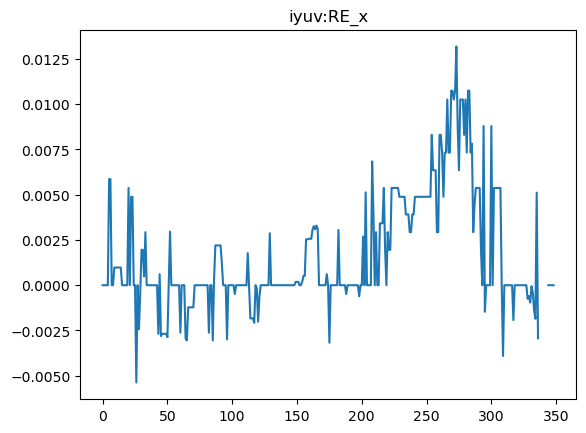

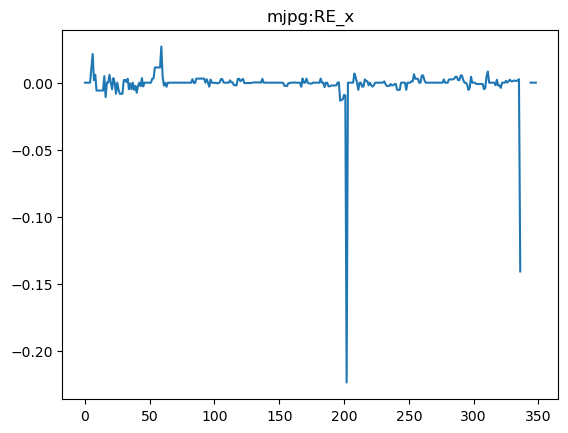

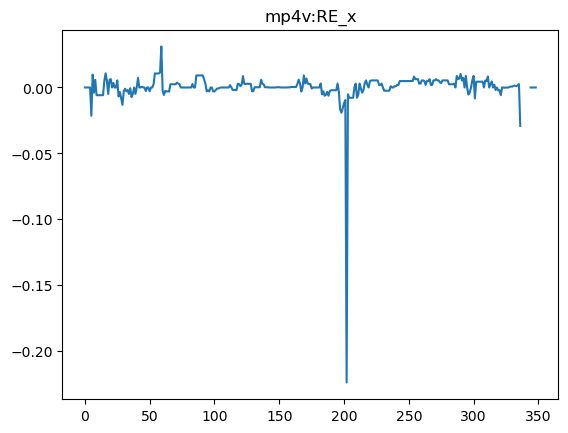

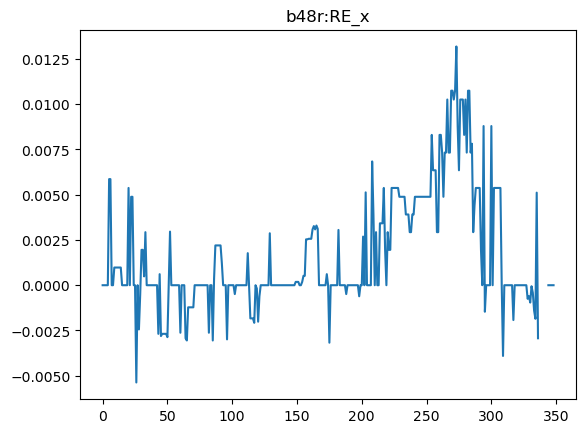

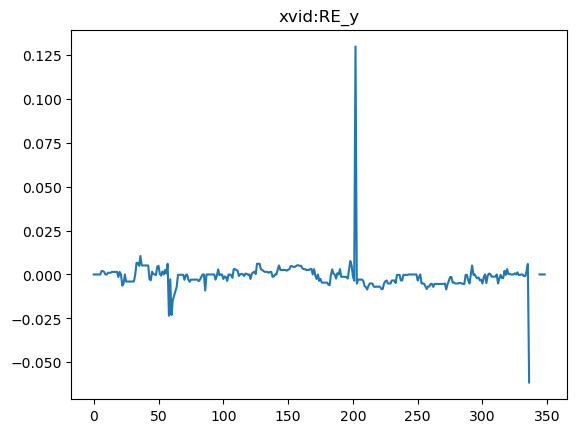

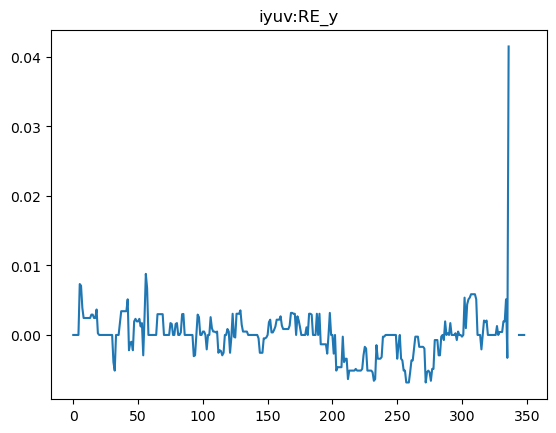

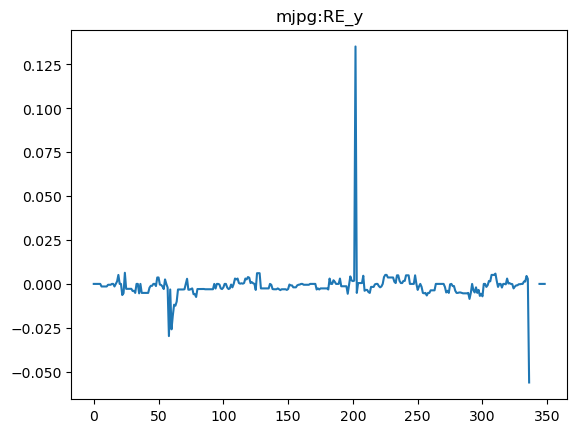

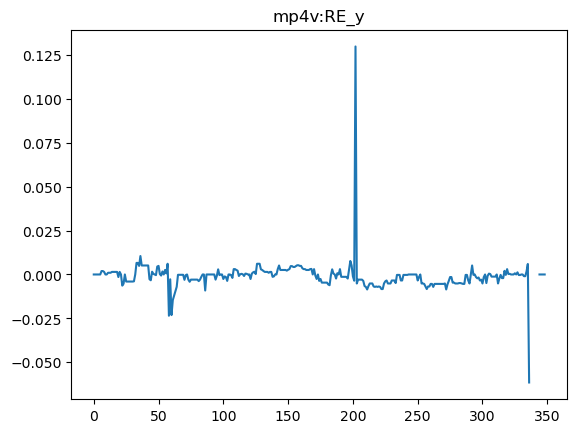

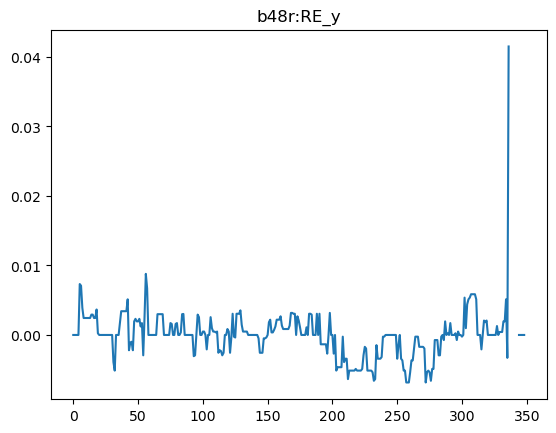

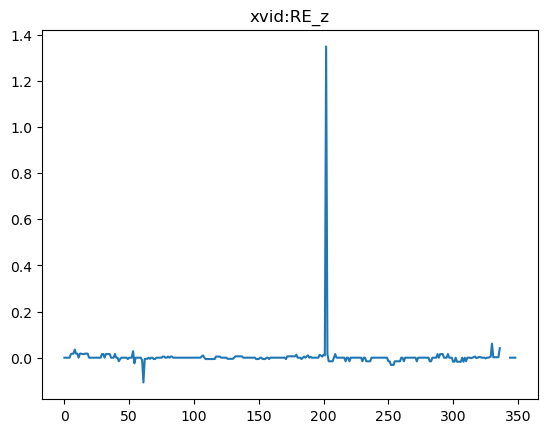

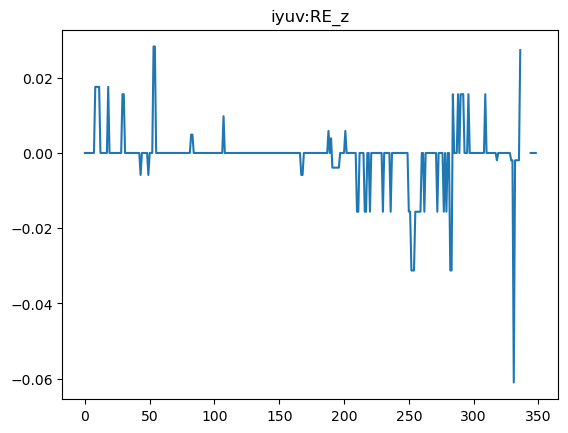

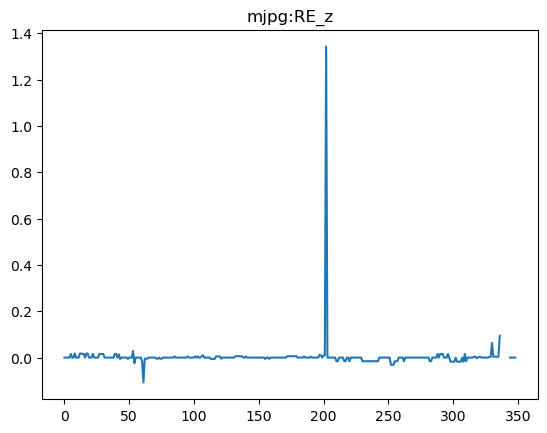

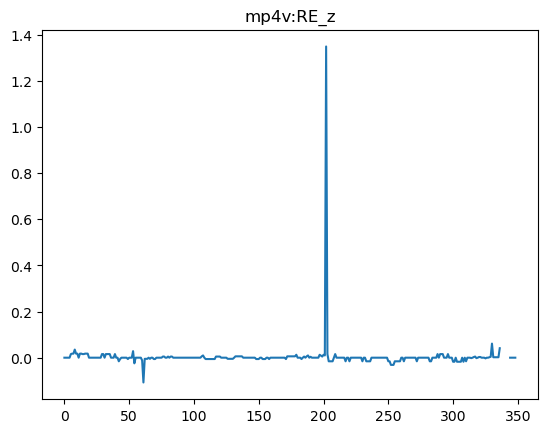

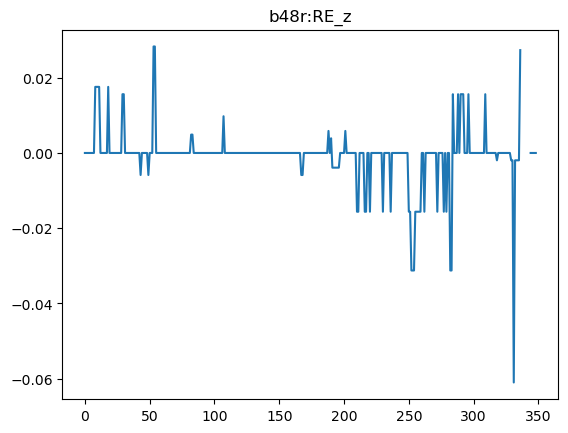

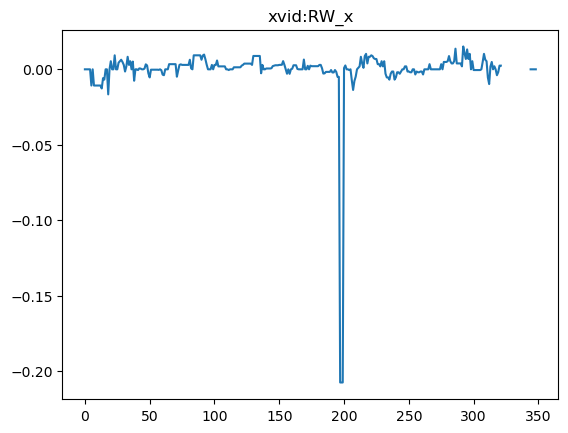

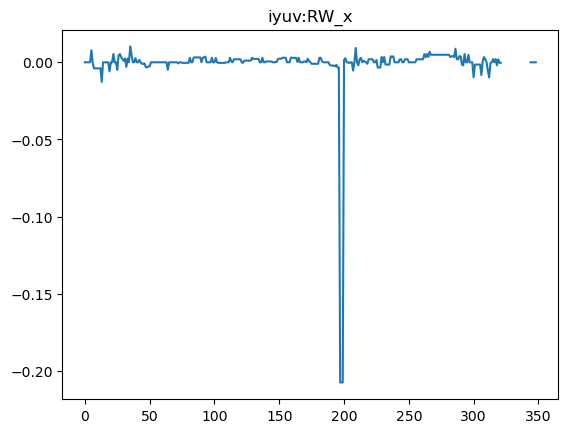

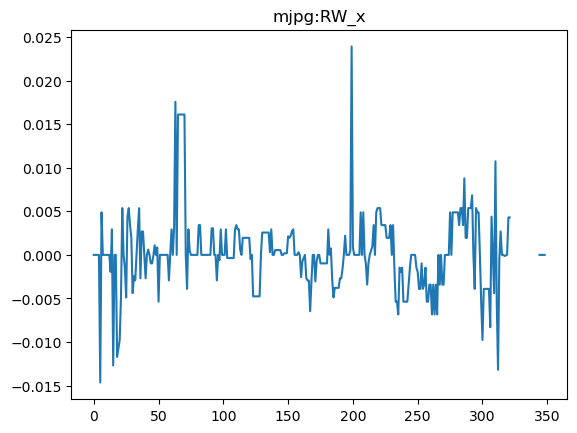

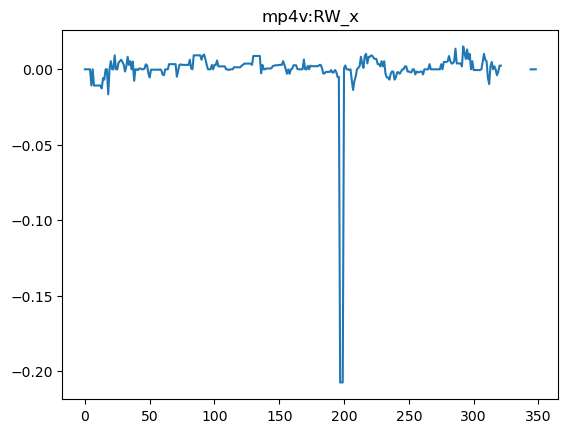

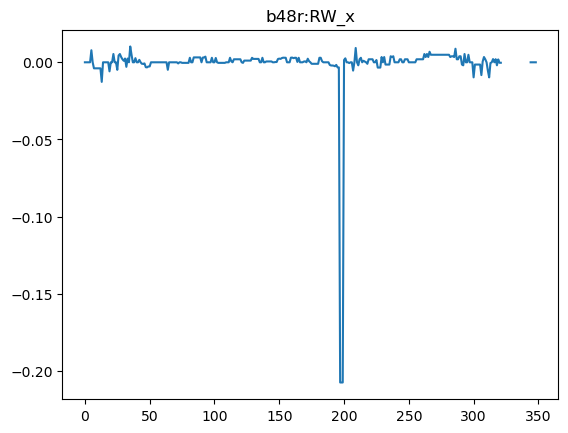

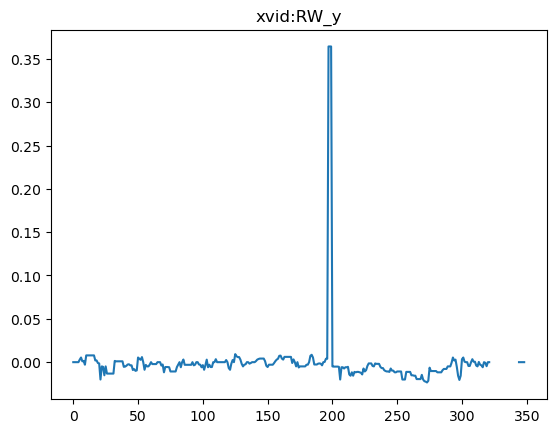

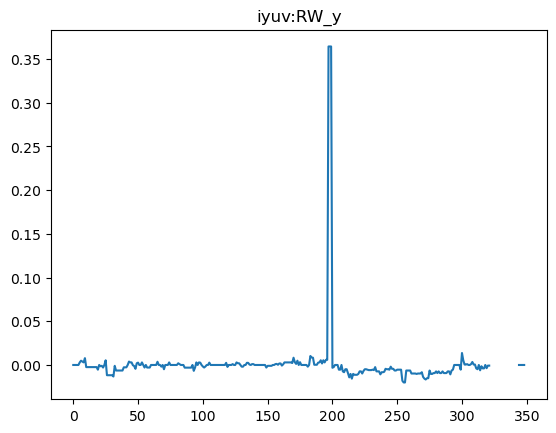

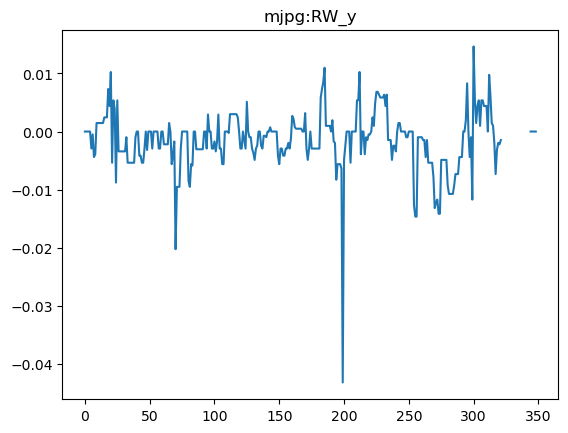

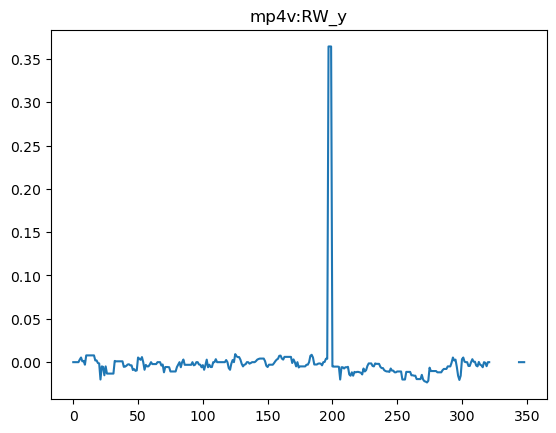

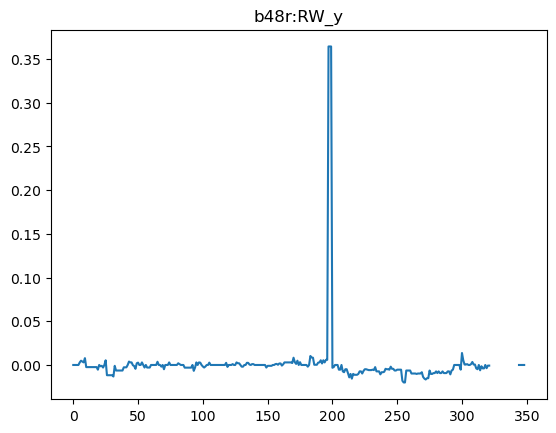

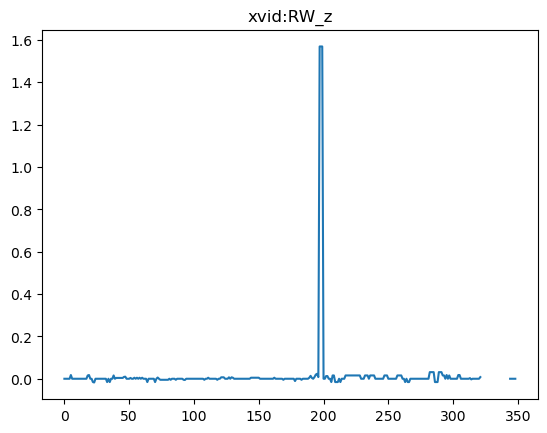

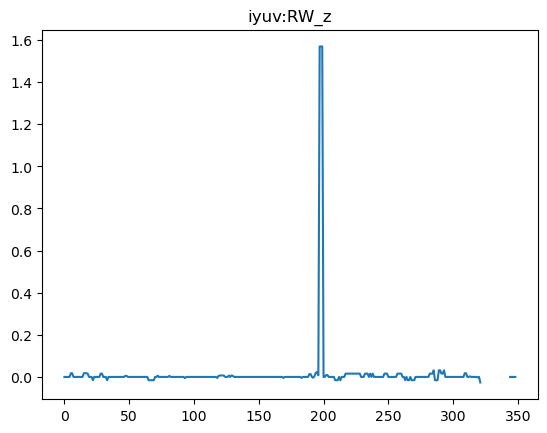

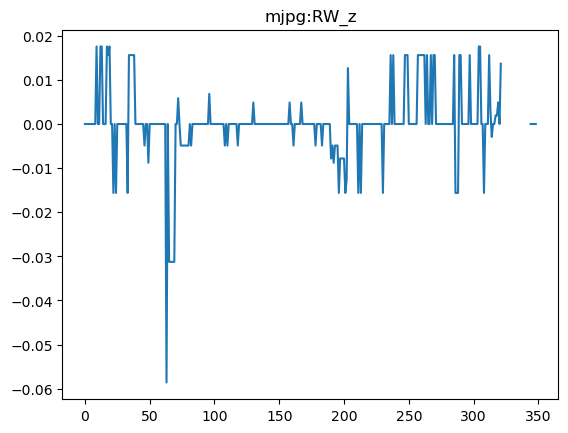

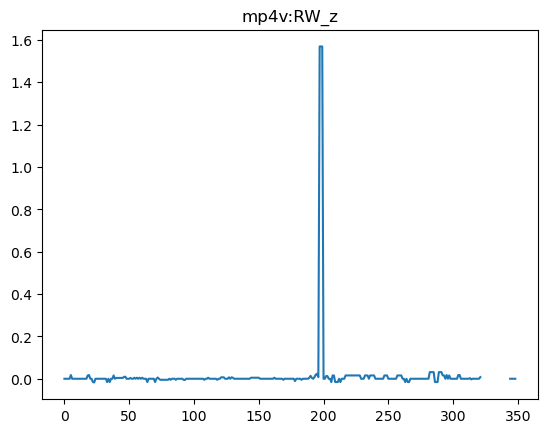

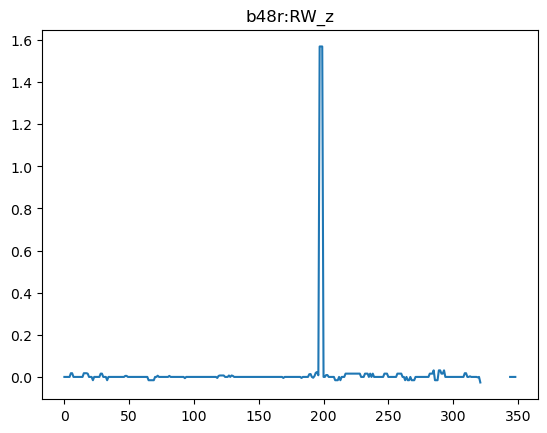

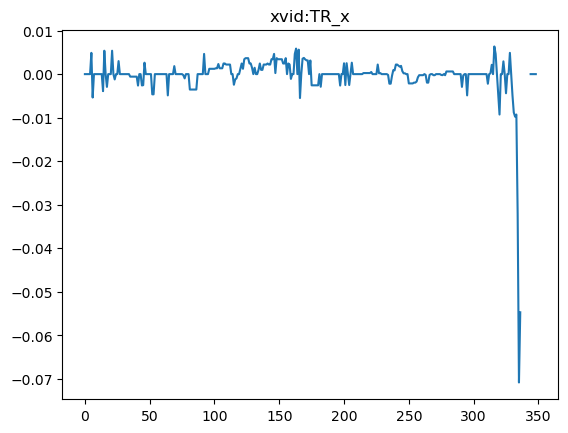

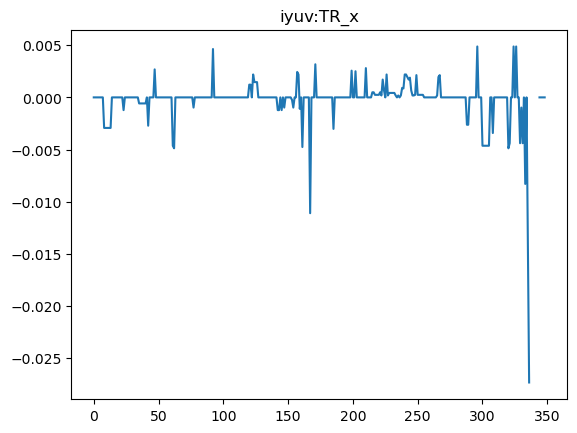

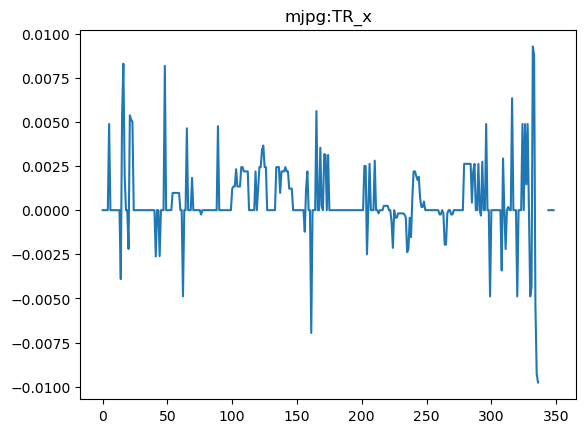

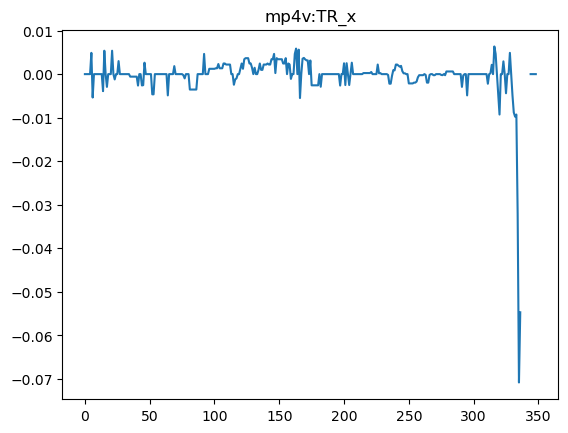

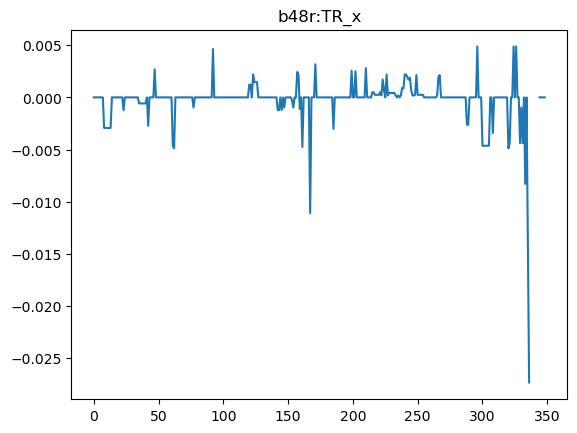

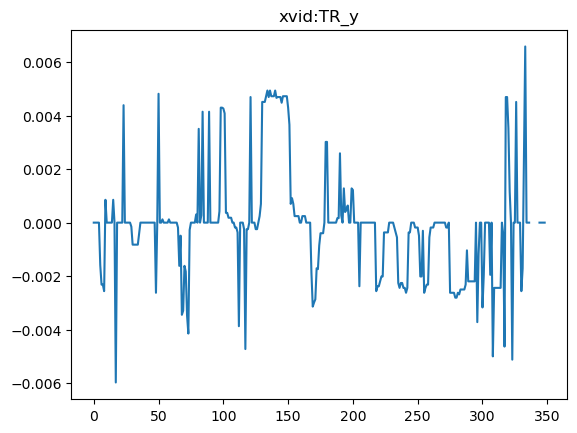

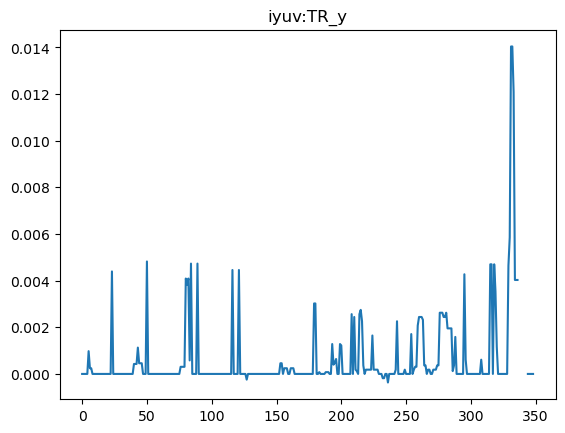

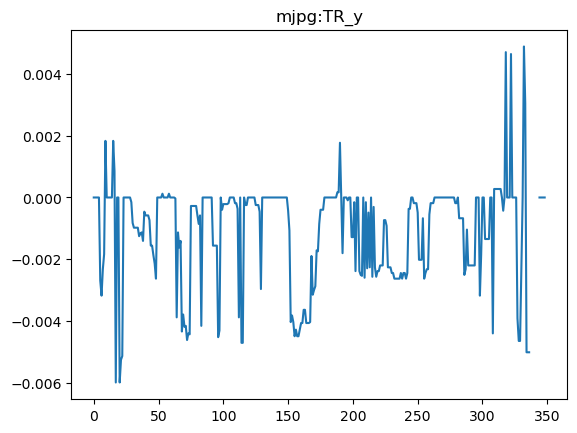

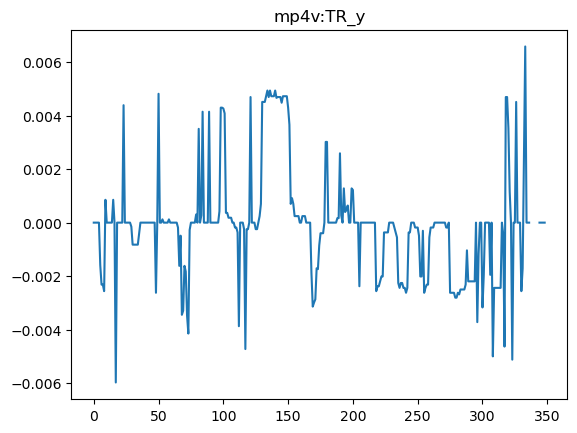

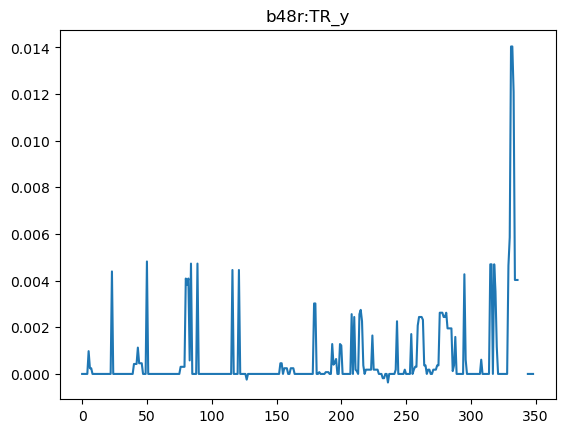

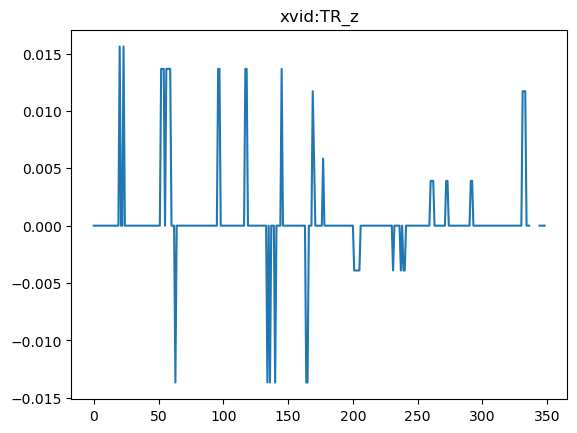

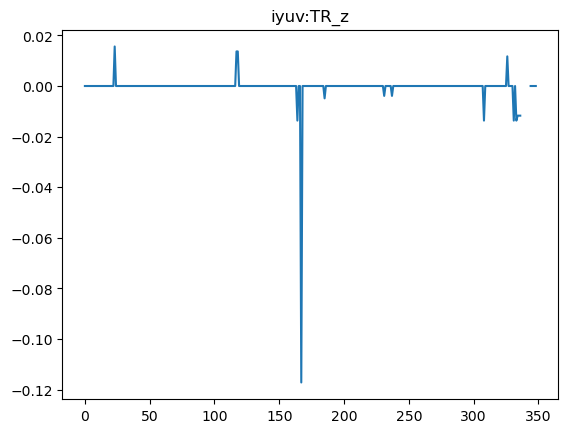

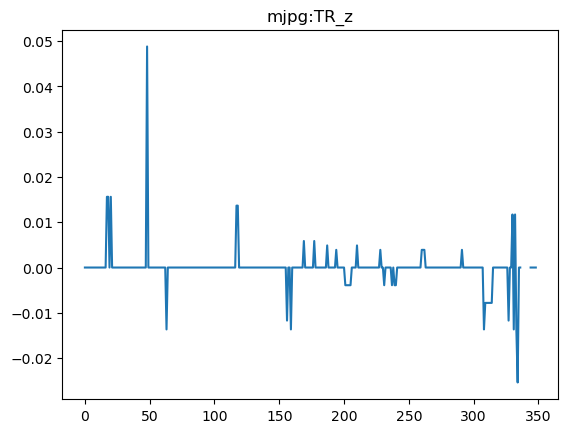

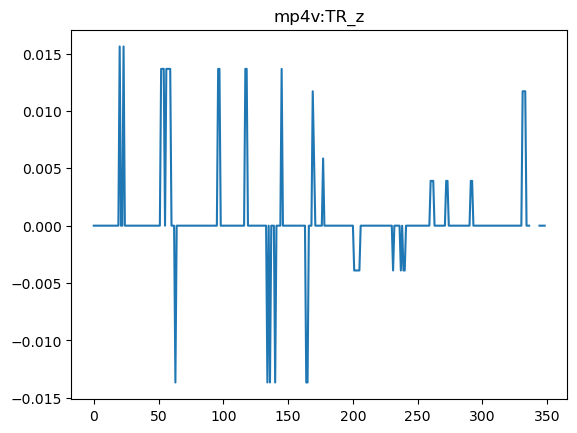

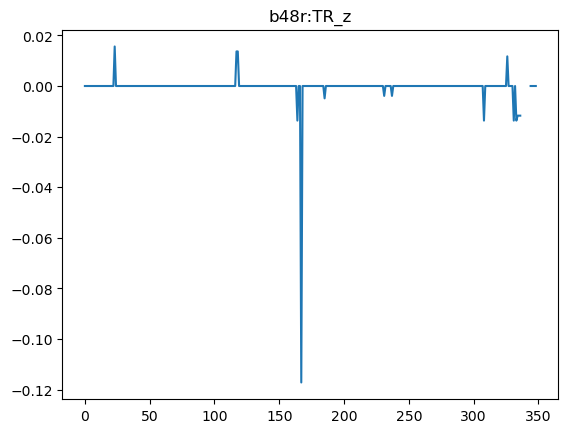

In [ ]:
c = 0
prs = Presentation()

# Iterate over each column name, excluding the first column
for i in columns[1:]:
    for j in range(1, len(dfnames)):
        try:
            # Create a new figure and axis
            fig, ax = plt.subplots()

            # Plot the difference between the corresponding columns of dfs[0] and dfs[j]
            ax.plot(dfs[j].index, dfs[0][i] - dfs[j][i])
            plt.title(dfnames[j] + ':' + i)
            plt.savefig('graph.jpg')
            img = 'graph.jpg'

            # Create a new slide with a picture and text
            title_slide_layout = prs.slide_layouts[0]
            slide = prs.slides.add_slide(title_slide_layout)
            pic = slide.shapes.add_picture(img, Inches(1), Inches(1), height=Inches(5))

            left = top = 1
            width = height = 3
            txBox = slide.shapes.add_textbox(left, top, width, height)
            tf = txBox.text_frame

            # Calculate the RMSE between dfs[0][i] and dfs[j][i]
            error = str(RMSE(dfs[0][i].tolist(), dfs[j][i].tolist(), range(len(dfs[0][i].tolist())), range(len(dfs[0][i].tolist()))))
            tf.text = "RMSE " + dfnames[j] + '-' + i + ' : ' + error
            prs.save('format_error_graphs.pptx')

        except:
            continue


In [ ]:
def calculate_rmse(true_df, predicted_df):
    rmse = np.sqrt(((true_df - predicted_df) ** 2).mean().mean())
    return rmse

# Add a slide at the end of the presentation
end_slide_layout = prs.slide_layouts[1]
end_slide = prs.slides.add_slide(end_slide_layout)

# Add a text box to the end slide and set its text as RMSE value
left = top = width = height = Inches(2)
txBox = end_slide.shapes.add_textbox(left, top, width, height)
tf = txBox.text_frame
errors=[]
for i,j in zip(dfs[1:],dfnames[1:]):
    print('RMSE',j,' : ',calculate_rmse(dfs[0],i))   
    errors.append('RMSE '+j+' : '+str(calculate_rmse(dfs[0],i))+'\n')

tf.text = 'Cumulative error for each codec \n'+''.join(errors)

# Save the presentation to a file
prs.save("format_error_graphs.pptx")

RMSE xvid  :  0.046384703669972605
RMSE iyuv  :  0.033490452416486
RMSE mjpg  :  0.028191299514580947
RMSE mp4v  :  0.046384703669972605
RMSE b48r  :  0.033490452416486
